<a href="https://colab.research.google.com/github/tvml/ml2425/blob/master/codici/overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

In [2]:
import scipy as sc
import scipy.stats as stats
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

plt.style.use('fivethirtyeight')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256)))

bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

Definizione della funzione (sconosciuta) alla base del dataset

In [4]:
def f(x):
    return np.sin(x)*(np.cos(x))**2

Funzione che genera i valori target di un insieme di punti, associando ad un valore $x$ il valore 
$y=f(x)+\varepsilon$, con $\varepsilon$ distribuito secondo una gaussiana di media $0$ e varianza $0.1$ 

In [5]:
def p(r):
    return [stats.norm.rvs(loc=f(x), scale=0.1, size=1) for x in r]

Numero di elementi nel training e nel test set

In [6]:
n_train = 30
n_test = 30

Genera casualmente il training set

In [7]:
x_train = stats.uniform.rvs(size=n_train, loc=-2, scale=4).reshape(-1,1)
y_train = np.array(p(x_train)).reshape(-1,1)

Genera casualmente il test set

In [8]:
x_test = stats.uniform.rvs(size=n_test, loc=-2, scale=4).reshape(-1,1)
y_test = np.array(p(x_test)).reshape(-1,1)

Riporta il plot della funzione e i due dataset

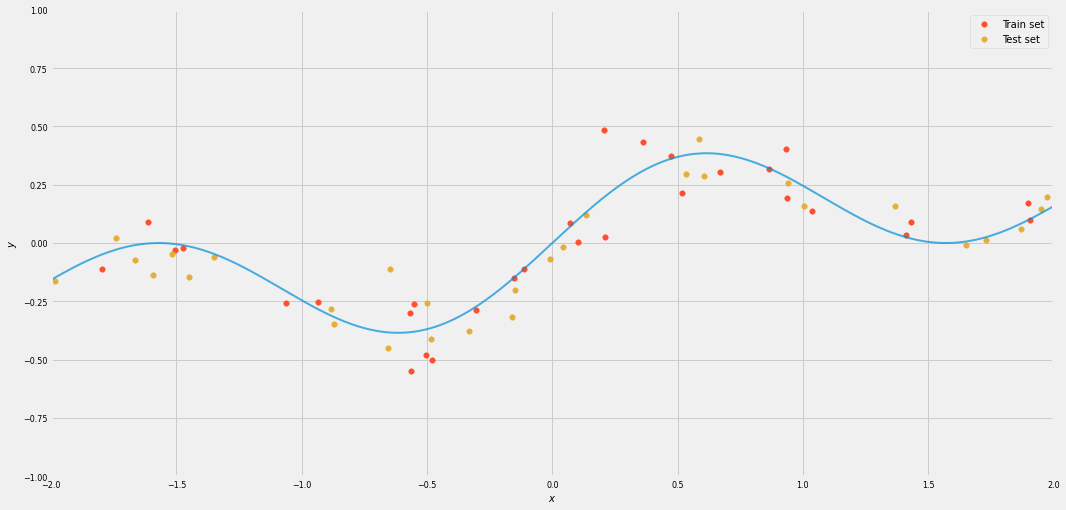

In [24]:
fig, ax = plt.subplots(figsize=(16, 8))
x = np.linspace(-2, 2, 1000)
plt.plot(x, f(x), linewidth=2, alpha = .7)
plt.scatter(x_train, y_train, s=30, color='C1', label='Train set')
plt.scatter(x_test, y_test, s=30, color='C2', label='Test set')
plt.xlim(-2, 2)
plt.ylim(-1,1)
plt.xlabel('$x$')
plt.ylabel(r'$y$')
plt.legend()
plt.show()

Funzione che effettua le previsioni di $y$ per tutti gli elementi in $t$ mediante un polinomio i cui coefficienti sono specificati in $\theta$

In [12]:
def predictions(theta, x):
    return np.polyval(theta[::-1],x)

Funzione di costo, definita sul dataset $x,t$ e sul modello rappresentato dai coefficienti $\theta$ del polinomio

In [13]:
def cost(theta, x, t):
    n = x.shape[0]
    y = predictions(theta,x)
    return round(np.sqrt(np.sum((t-y)**2)/float(2*n)), 4)

Grado del polinomio utilizzato

In [25]:
degree = 6

Calcola matrice delle nuove features corrispondenti ai termini $1, x, x^2, \ldots$

In [26]:
X = np.ones(n_train).reshape(-1,1)
Z = x_train
for i in range(degree):
    X = np.column_stack((X, Z))
    Z = Z*x_train

Calcola vettore con valore ottimo dei coefficienti

In [27]:
theta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)) , X.T), y_train)

Calcola costo su train e test set

In [28]:
c_train = cost(theta,x_train,y_train)
c_test = cost(theta,x_test,y_test)

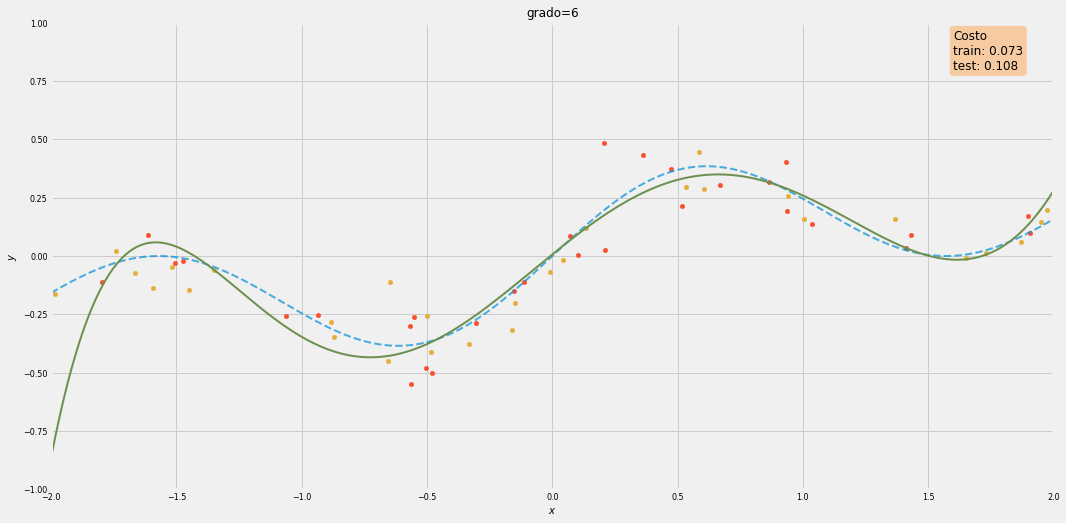

In [29]:
fig, ax = plt.subplots(figsize=(16, 8))
x = np.linspace(-2, 2, 1000)
plt.plot(x, f(x), lw=2, ls='dashed', alpha = .7)
plt.scatter(x_train, y_train, s=20, color='C1')
plt.scatter(x_test, y_test, s=20, color='C2')
plt.plot(x, predictions(theta,x), color='C3', linewidth=2, alpha=1)
plt.xlim(-2, 2)
plt.ylim(-1,1)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('grado={0:d}'.format(degree), fontsize=12)
plt.text(0.9, 0.9, 'Costo\ntrain: {0:.3f}\ntest: {1:.3f}'.format(c_train, c_test), fontsize=12, 
         transform=ax.transAxes, bbox=bbox_props)
plt.show()

Calcola costo su training e test set al variare del grado del polinomio 

In [30]:
maxdeg = 20
costs_train =  []  
costs_test =  [] 

In [31]:
for degree in range(0, maxdeg):
    X = np.ones(n_train).reshape(-1,1)
    Z = x_train
    for i in range(degree):
        X = np.column_stack((X, Z))
        Z=Z*x_train
    
    theta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y_train)
    
    costs_train.append(cost(theta,x_train,y_train))
    costs_test.append(cost(theta,x_test,y_test))

In [35]:
df = pd.DataFrame()
df['train'] = costs_train
df['test'] = costs_test
df['ratio'] = df.test/df.train

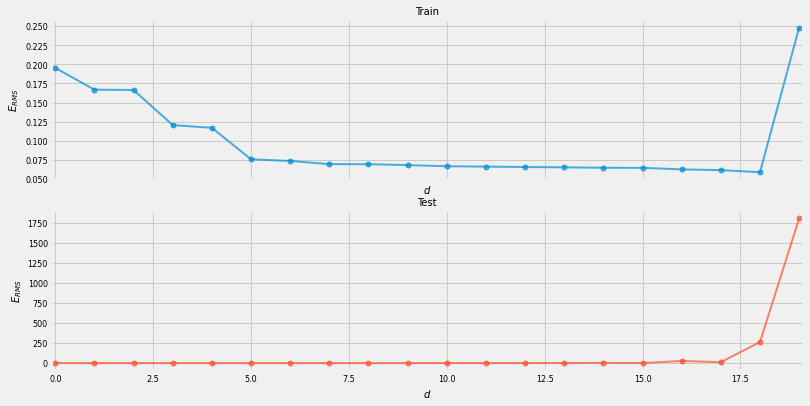

In [33]:
top = maxdeg
fig, axarr = plt.subplots(2, sharex=True, figsize=(12, 6))
axarr[0].plot(df.index[:top], df.train[:top], linewidth=2, alpha = .7, marker = 'o', markersize=5)
axarr[0].set_title('Train')
axarr[0].set_xlabel('$d$')
axarr[0].set_ylabel('$E_{RMS}$')
axarr[1].plot(df.index[:top], df.test[:top], linewidth=2, alpha = .7, marker = 'o', markersize=5, color='C1')
axarr[1].set_title('Test')
plt.xlim(-0.1, df.index[top-1]+.1)
axarr[1].set_xlabel('$d$')
axarr[1].set_ylabel('$E_{RMS}$')
plt.show()

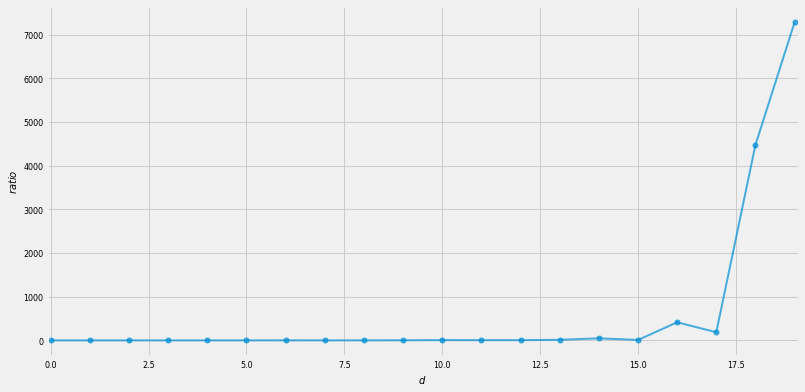

In [34]:
top = maxdeg
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(df.index[:top], df.ratio[:top], linewidth=2, alpha = .7, marker = 'o', markersize=5)
plt.xlim(-0.1, df.index[top-1]+.1)
plt.xlabel('$d$')
plt.ylabel(r'$ratio$')
plt.show()